In [1]:
!pip install ninja
!git clone https://github.com/NVlabs/stylegan3.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 15.6 MB/s eta 0:00:00
Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.16 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [2]:
import sys
sys.path.append('./stylegan3')

import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
from PIL import Image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

import torch_utils
import legacy
import dnnlib

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load in the trained Stylegan3 model
network_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema']
        G = G.eval().requires_grad_(False).to(device)
c = None

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def get_latents(amount, seed, shape = 512):
    latents = torch.from_numpy(np.random.RandomState(seed).randn(amount, shape)).cuda()
    w = torch.empty(amount, 16, shape)
    for i in range(latents.shape[0]):
        w[i] = G.mapping(latents[i][None], c)
    return latents, w

def face_from_latent(net, latents, img_size, show_face = False, use_w=False, outdir = None):
    outputs = torch.empty((len(latents), 3, img_size, img_size))
    transform=transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    for i, latent in enumerate(latents):
        if use_w:
            face = net.synthesis(latent[None], noise_mode = "none")
        else:
            face = net(latent[None], c)
        face = np.clip(np.rint((face.cpu() + 1.0) / 2.0 * 255.0), 0.0, 255.0).numpy().astype(np.uint8)
        face = face.transpose((0, 2, 3, 1))
        img = Image.fromarray(face[0], 'RGB')
        img = img.resize((img_size,img_size), resample = PIL.Image.LANCZOS)
        if show_face:
            plt.axis('off')
            plt.title("Face "+str(i))
            plt.imshow(img)
            plt.show()
        if not outdir is None:
          img.save(outdir + "Image %d.png" % i)
        img = transform(img)
        outputs[i] = img
    return outputs

def train(netD, netG, num_iters, batch_size, img_size, seed, criterion, optimizer):
    losses = []
    for i in range(num_iters):
        z, w = get_latents(batch_size, np.random.seed(seed))
        z = z.to(torch.float32).to(device)
        w = w.to(device) # naar float32?
        x = face_from_latent(netG, w, img_size, use_w = True).to(device)

        netD.zero_grad()

        output = netD(x).squeeze()

        errD = criterion(output, w[:,0])
        errD.backward()
        optimizer.step()
        
        if i % 5 == 0:
          print('[%d/%d]\tLoss_D: %.4f' % (i+1, num_iters, errD.item()))

        losses.append(errD.item())

    return losses

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels = 3, feature_maps = 64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 512, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Set number of gpu's and device
img_size = 64

torch.Size([5, 16, 512])


C:\Users\Kieran\AppData\Local\Temp\ipykernel_10248\2306606543.py:27: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((img_size,img_size), resample = PIL.Image.LANCZOS)


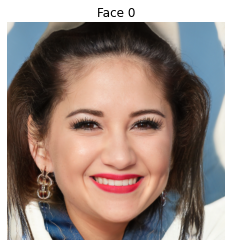

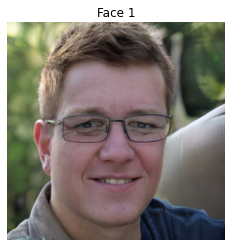

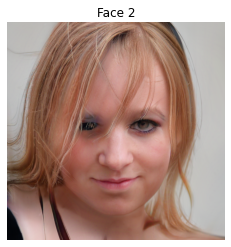

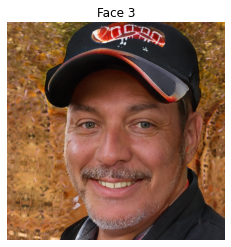

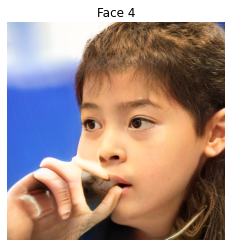

In [ ]:
seed = 42
outdir = 'output/'
os.makedirs(outdir, exist_ok=True)
batch_sz = 5

z, w = get_latents(batch_sz, seed)
z = z.to(torch.float32).to(device)
w = w.to(device) # naar float32?
print(w.shape)

outputs = face_from_latent(G, w, 1024, show_face = True, use_w = True, outdir=outdir).to(device)

In [ ]:
netD_Adam_W = Discriminator().to(device)
netD_Adam_W.apply(weights_init)
optimizerD_Adam_W = optim.Adam(netD_Adam_W.parameters(), lr=0.0002)
criterion = nn.MSELoss()

# checkpoint = torch.load('training/netD_adam_w.pt')
# netD_Adam_W.load_state_dict(checkpoint['model_state_dict'])
# optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
# iter = checkpoint['iter']
# loss = checkpoint['loss']

print(netD_Adam_W)
# print(iter)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
4000


In [ ]:
# Number of training epochs
num_iters = 5000

# Set batch size, for number of generated samples per epoch
batch_size = 32

# Set random seed
seed = 42

In [ ]:
losses_adam_w = train(netD_Adam_W, G, num_iters, batch_size, img_size, seed, criterion, optimizerD_Adam_W)

[1/1000]	Loss_D: 0.4888
[6/1000]	Loss_D: 0.4998
[11/1000]	Loss_D: 0.4959
[16/1000]	Loss_D: 0.4781
[21/1000]	Loss_D: 0.4707
[26/1000]	Loss_D: 0.4967
[31/1000]	Loss_D: 0.4810
[36/1000]	Loss_D: 0.4936
[41/1000]	Loss_D: 0.4688
[46/1000]	Loss_D: 0.4788
[51/1000]	Loss_D: 0.4832
[56/1000]	Loss_D: 0.4834
[61/1000]	Loss_D: 0.4732
[66/1000]	Loss_D: 0.4726
[71/1000]	Loss_D: 0.4648
[76/1000]	Loss_D: 0.4989
[81/1000]	Loss_D: 0.4853
[86/1000]	Loss_D: 0.4949
[91/1000]	Loss_D: 0.5016
[96/1000]	Loss_D: 0.4747
[101/1000]	Loss_D: 0.4868
[106/1000]	Loss_D: 0.4991
[111/1000]	Loss_D: 0.4653
[116/1000]	Loss_D: 0.4860
[121/1000]	Loss_D: 0.4757
[126/1000]	Loss_D: 0.4806
[131/1000]	Loss_D: 0.4897
[136/1000]	Loss_D: 0.4950
[141/1000]	Loss_D: 0.4967
[146/1000]	Loss_D: 0.4744
[151/1000]	Loss_D: 0.4820
[156/1000]	Loss_D: 0.4844
[161/1000]	Loss_D: 0.4952
[166/1000]	Loss_D: 0.4700
[171/1000]	Loss_D: 0.4695
[176/1000]	Loss_D: 0.4703
[181/1000]	Loss_D: 0.4872
[186/1000]	Loss_D: 0.4997
[191/1000]	Loss_D: 0.4950
[196/100

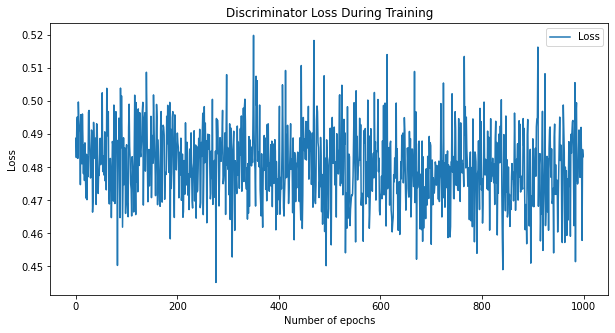

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses_adam_w,label="Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
iter = 5000
path = '/content/drive/MyDrive/Internship/training/netD_stylegan3-1024_w_5000.pt'
loss = losses_adam_w[-1]

torch.save({
    'iter': iter,
    'model_state_dict': netD_Adam_W.state_dict(),
    'optimizer_state_dict': optimizerD_Adam_W.state_dict(),
    'loss': loss,
}, path)